## Examen Final Simulación - UPS Turismo
#### Por: Robbyn Reyes

In [26]:
## se importan las librerias 
import collections
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats 

In [60]:
## Lugares de mayor afluencia
## 1. Guayaquil
## 2. Quito
## 3. Riobamba
## 4. Cuenca
## 5. Salinas
## 6. Santa Elena

VELOCIDAD_LLEGADA = 20
NUM_BOLETO = 40
TIEMPO_SIMULACION = 7*24*60

boletos_lugares={}

nBus=[0,0,0,0,0]

aux=0
aux2=0
ventas=0
ventasPorDia=[]

lugaresDestino = {'Guayaquil':0, 'Quito':0, 'Riobamba':0, 'Cuenca':0, 'Salinas':0, 'Santa Elena':0}
lugaresOrigen = {'Guayaquil':0, 'Quito':0, 'Riobamba':0, 'Cuenca':0, 'Salinas':0, 'Santa Elena':0}

bus1={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
bus2={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
bus3={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
bus4={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
bus5={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}

def subida_al_bus(env, nbus, pasajeros, dia):
  global nBus
  global bus1
  global bus2
  global bus3
  global bus4
  global bus5

  with buses.request() as bus:
    yield bus
    nB=0
    for i in range(len(nBus)):
        if nBus[i] == 0:
            nB=i+1
            nBus[i] = str(bus)
            a='bus'+str(nB)
            break
    if nB==1:
      bus1[dia]+=pasajeros

    elif nB==2:
      bus2[dia]+=pasajeros
      
    elif nB==3:
      bus3[dia]+=pasajeros

    elif nB==4:
      bus4[dia]+=pasajeros

    elif nB==5:
      bus5[dia]+=pasajeros

    nbus=nbus.replace('bus',a)
    yield env.process(viaje(env, nbus))
    nBus[nB-1]=0
    

def viaje(env, bus):
    while True:
        mu, sigma = 6*60, 4*60 # media y desvio estandar
        normal = stats.norm(mu, sigma)  
        aleatorios = normal.rvs(1) 
        if aleatorios>=0:
            break
    yield env.timeout(aleatorios)
    print('el ', bus, 'llego a las ', env.now, 'a su destino')
    yield env.timeout(aleatorios)
    print('el ', bus, 'regreso a las ', env.now)


def viaje_antes(env,bus, pasajeros):
  print('el bus salio antes')
  subida_al_bus(env, bus, pasajeros)


def ventaBoletos(env, num_boletos, lugar, lugar2,buses):
  # print('entra')
  global aux
  global aux2
  global ventas
  global ventasPorDia
  global lugaresDestino
  global lugaresOrigen
  with buses.contador.request() as asiento:
      
      resultado = yield asiento | agencia.sold_out[lugar]
      if asiento not in resultado:
        agencia.num_renegados[lugar] += 1
        return
      if agencia.num_boletos[lugar] < num_boletos:
        return
      else:
        lugaresDestino[lugar]+=num_boletos
        lugaresOrigen[lugar2]+=num_boletos
        aleatorios=0
        while True:
          mu, sigma = 10, 2 # media y desvio estandar
          normal = stats.norm(mu, sigma)  
          aleatorios = normal.rvs(1) 
          if aleatorios>=0:
              break
        yield env.timeout(aleatorios) 
        if lugar in list(boletos_lugares.keys()):
          a=boletos_lugares.get(lugar)
          a.append(num_boletos)
          boletos_lugares[lugar]=a
        else:
          boletos_lugares[lugar]=[num_boletos]
      agencia.num_boletos[lugar] -= num_boletos

      ro2=env.now/1440
      ro2= np.trunc(ro2)
      if ro2 != aux2:
        # print('dia: ',ro2)
        ventasPorDia.append(ventas)
        ventas=0
        aux2=ro2

      if agencia.num_boletos[lugar] < 2:
        bus='bus con destino '+lugar
        yield env.process(subida_al_bus(env,bus, 40, str(int(ro2[0])+1)))
        agencia.sold_out[lugar].succeed()
        agencia.tiempo_agotado[lugar] = env.now
        z=buses.num_boletos
        z[lugar]=40
        buses.num_boletos[lugar]=40
        buses.sold_out[lugar]=env.event()
        ventas+=40

      
      ro=env.now/60
      ro= np.trunc(ro)
      if ro != aux:
        bus='bus con destino '+lugar
        n=40-agencia.num_boletos[lugar]
        ventas+=n
        yield env.process(subida_al_bus(env,bus, n,str(int(ro2[0])+1)))
        agencia.sold_out[lugar].succeed()
        agencia.tiempo_agotado[lugar] = env.now
        z=buses.num_boletos
        z[lugar]=40
        buses.num_boletos[lugar]=40
        buses.sold_out[lugar]=env.event()
        aux=ro

def llegadaClientes(env, teatro, VELOCIDAD_LLEGADA):
  while True:
    yield env.timeout(VELOCIDAD_LLEGADA)
    bernoulli = stats.bernoulli(0.5)
    pGenero = bernoulli.rvs(1) 
    genero=''
    if pGenero == 1:
        genero='masculino'
    else:
        genero='femenino'
    
    edad=0
    while True:
        mu = 20 # parametro de forma 
        poisson = stats.poisson(mu) 
        edad=poisson.rvs(1)
        if edad>=18:
            break
    
    lugar = random.choices(teatro.lugares, teatro.probabilidad, k=1)
    lugar2 = random.choices(teatro.lugares, teatro.probabilidad, k=1)

    
    num_boletos = random.randint(1, 6)
    env.process(ventaBoletos(env, num_boletos, lugar[0],lugar2[0], teatro))


Agencia = collections.namedtuple('Teatro', 'contador, lugares, probabilidad, num_boletos, sold_out, tiempo_agotado, num_renegados')

print('UPS - Turismo')
env = simpy.Environment()

contador = simpy.Resource(env,capacity=6)
buses = simpy.Resource(env, 5)

lugares = ['Guayaquil', 'Quito', 'Riobamba', 'Cuenca', 'Salinas', 'Santa Elena']
probabilidad=[0.6,0.5,0.4,0.3,0.2,0.1]

num_boletos = {lugar: NUM_BOLETO for lugar in lugares}
sold_out = {lugar: env.event() for lugar in lugares}
tiempo_agotado = {lugar: None for lugar in lugares}
num_renegados = {lugar: 0 for lugar in lugares}

agencia = Agencia(contador, lugares, probabilidad, num_boletos, sold_out, tiempo_agotado, num_renegados)
env.process(llegadaClientes(env, agencia, VELOCIDAD_LLEGADA))
env.run(until=TIEMPO_SIMULACION)

UPS - Turismo
el  bus3 con destino Riobamba llego a las  [167.77679876] a su destino
el  bus3 con destino Riobamba regreso a las  [228.33017633]
el  bus1 con destino Guayaquil llego a las  [364.75267351] a su destino
el  bus4 con destino Riobamba llego a las  [386.43816548] a su destino
el  bus3 con destino Salinas llego a las  [481.63511848] a su destino
el  bus5 con destino Quito llego a las  [596.85613225] a su destino
el  bus2 con destino Cuenca llego a las  [626.09371109] a su destino
el  bus4 con destino Riobamba regreso a las  [641.66124276]
el  bus1 con destino Guayaquil regreso a las  [658.17846601]
el  bus3 con destino Salinas regreso a las  [734.94006063]
el  bus4 con destino Quito llego a las  [756.57987353] a su destino
el  bus4 con destino Quito regreso a las  [871.49850429]
el  bus1 con destino Santa Elena llego a las  [996.14814846] a su destino
el  bus5 con destino Quito regreso a las  [1038.82164809]
el  bus2 con destino Cuenca regreso a las  [1159.96084818]
el  bus4 

### Venta de tickets

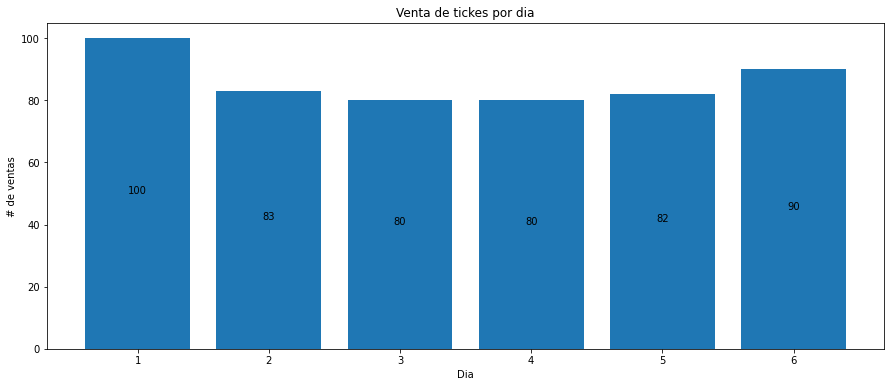

In [61]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1]/2,y_list[i-1], ha="center")

eje_x = list(range(1,len(ventasPorDia)+1))
eje_y = ventasPorDia

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Venta de tickes por dia')
plt.ylabel('# de ventas')
plt.xlabel('Dia')
plt.show()

### Personas que se quedaron sin tickets

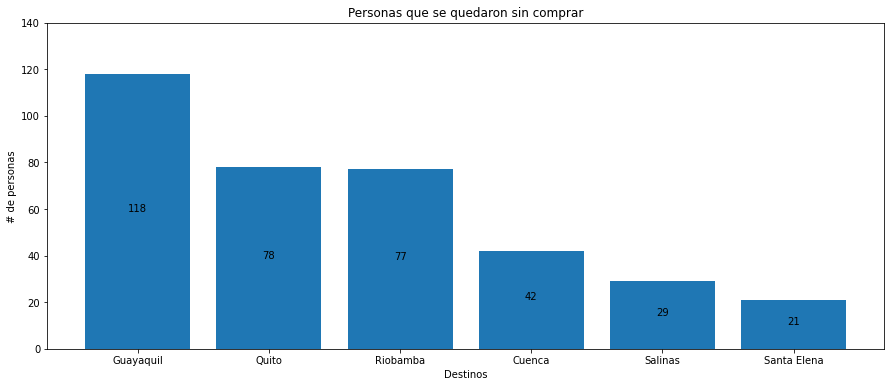

In [62]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
eje_x = list(agencia.num_renegados.keys())
eje_y = list(agencia.num_renegados.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Personas que se quedaron sin comprar')
plt.ylabel('# de personas')
plt.xlabel('Destinos')
plt.ylim([0, 140])
plt.show()

### Lugares de origen y destino mas visitados

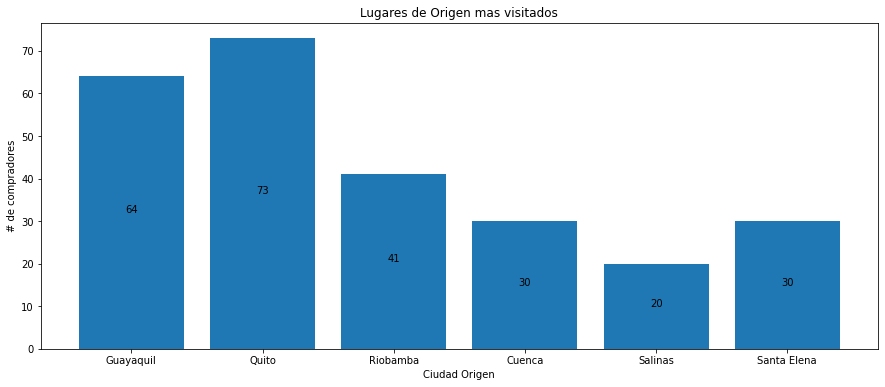

In [63]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
eje_x = list(lugaresOrigen.keys())
eje_y = list(lugaresOrigen.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Lugares de Origen mas visitados')
plt.ylabel('# de compradores')
plt.xlabel('Ciudad Origen')
plt.show()

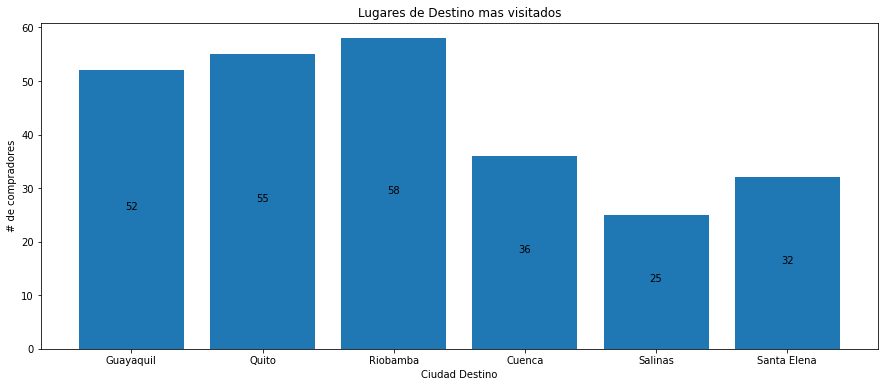

In [64]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
eje_x = list(lugaresDestino.keys())
eje_y = list(lugaresDestino.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Lugares de Destino mas visitados')
plt.ylabel('# de compradores')
plt.xlabel('Ciudad Destino')
plt.show()

### Numero de buses y uso diario

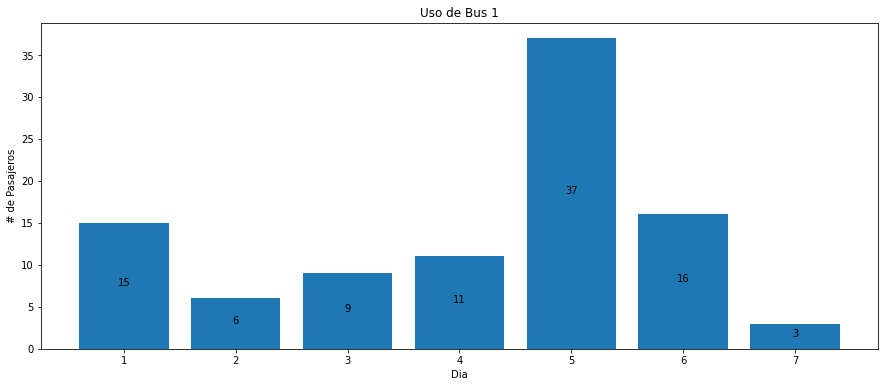

In [65]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
## Bus 1
eje_x = list(bus1.keys())
eje_y = list(bus1.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Uso de Bus 1')
plt.ylabel('# de Pasajeros')
plt.xlabel('Dia')
plt.show()

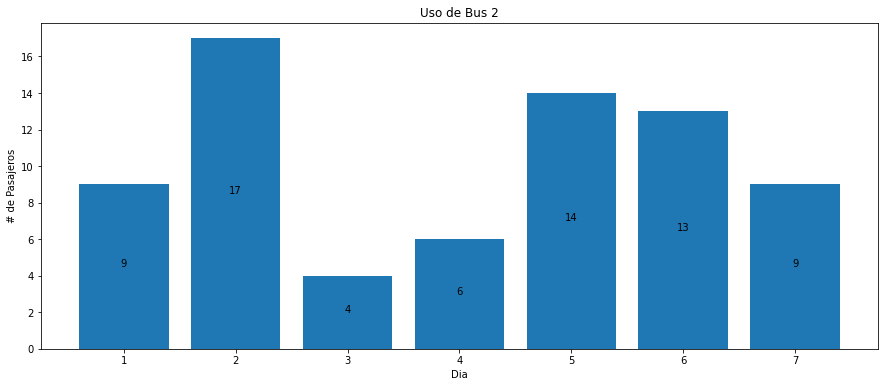

In [66]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
## Bus 2
eje_x = list(bus2.keys())
eje_y = list(bus2.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Uso de Bus 2')
plt.ylabel('# de Pasajeros')
plt.xlabel('Dia')
plt.show()

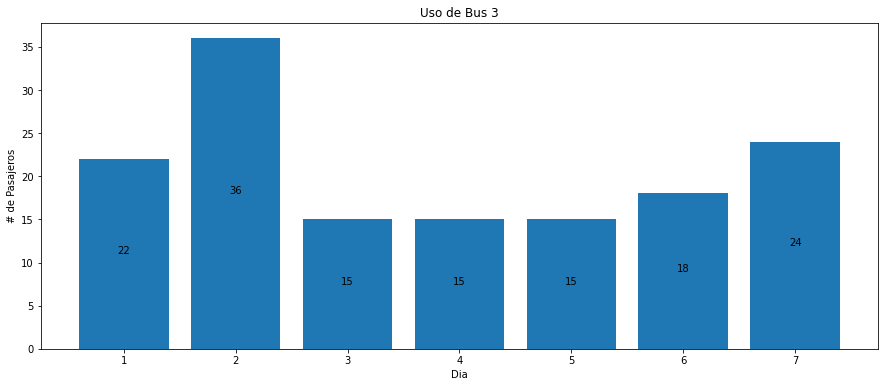

In [67]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
## Bus 3
eje_x = list(bus3.keys())
eje_y = list(bus3.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Uso de Bus 3')
plt.ylabel('# de Pasajeros')
plt.xlabel('Dia')
plt.show()

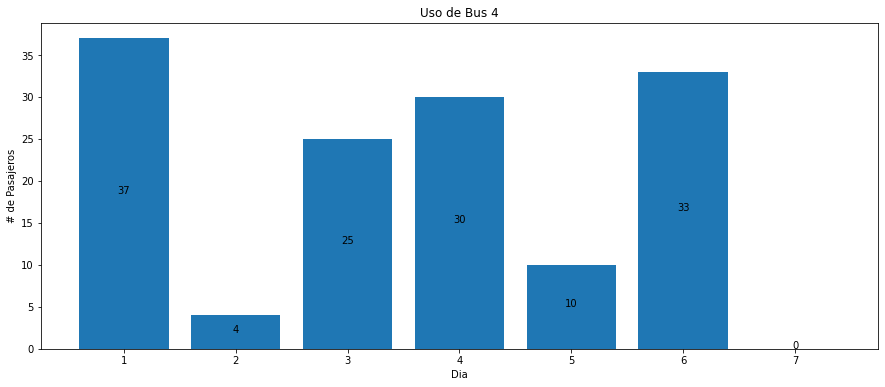

In [68]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
## Bus 4
eje_x = list(bus4.keys())
eje_y = list(bus4.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Uso de Bus 4')
plt.ylabel('# de Pasajeros')
plt.xlabel('Dia')
plt.show()

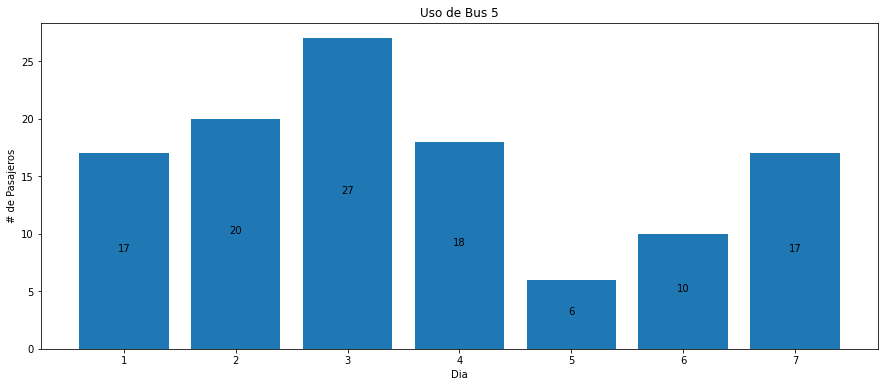

In [69]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,y_list[i], ha="center")
        
## Bus 5
eje_x = list(bus5.keys())
eje_y = list(bus5.values())

plt.figure(figsize=(15, 6))
plt.bar(eje_x, eje_y)
add_value_label(eje_x, eje_y)

plt.title('Uso de Bus 5')
plt.ylabel('# de Pasajeros')
plt.xlabel('Dia')
plt.show()